## **Laboratorio: Redes Generativas Antagónicas (GANs) para Generación de Imágenes MNIST**

**¿Qué es una GAN?**

Una Red Generativa Antagónica (GAN) es un tipo de modelo de aprendizaje profundo compuesto por dos redes neuronales que compiten entre sí:

* Generador (Generator): Crea datos falsos (por ejemplo, imágenes) a partir de ruido aleatorio.
* Discriminador (Discriminator): Evalúa si los datos recibidos son reales (del conjunto de datos) o falsos (generados por el generador).

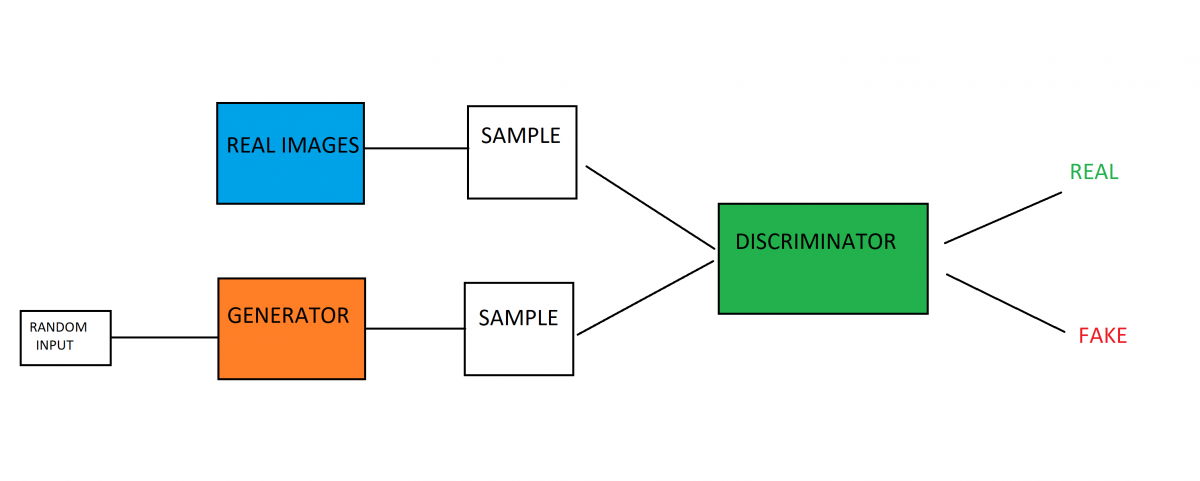

**Objetivo del Ejercicio**

Implementar una GAN Vanilla en PyTorch para generar imágenes de dígitos escritos a mano similares a las del conjunto de datos MNIST. A lo largo del ejercicio se realizará lo siguiente:

* Construcción de Modelos: Definir arquitecturas básicas para el generador y el discriminador.
* Entrenamiento de GANs: Alternar el entrenamiento entre el generador y el discriminador utilizando funciones de pérdida adecuadas.
* Visualización de Resultados: Generar y visualizar imágenes para evaluar el desempeño del generador.

**Celda 1: Instalación e Importación de Librerías**

In [2]:
# Instalación de librerías necesarias
# Comenta la siguiente línea si ya tienes instalada la librería torchvision
!pip install torchvision

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


Explicación: En esta celda, importamos todas las librerías necesarias para nuestro proyecto:

* torch y torch.nn: Para construir y entrenar las redes neuronales.
*torch.optim: Para utilizar optimizadores como Adam.
* torchvision: Para manejar y transformar el conjunto de datos MNIST.
* matplotlib.pyplot: Para visualizar las imágenes generadas.
* tqdm: Para mostrar barras de progreso durante el entrenamiento.

**Celda 2: Configuración de Parámetros y Preparación del Conjunto de Datos**

In [4]:
# Configuración de parámetros
batch_size = 64
Z_dim = 100  # Dimensión del espacio latente
learning_rate = 0.0002
num_epochs = 50
image_size = 28
image_channels = 1

# Transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

# Cargar el conjunto de datos MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Dispositivo: GPU si está disponible, sino CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Usando dispositivo: {device}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 53353700.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1746125.26it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11782499.74it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2996779.73it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Usando dispositivo: cpu


Explicación:

Parámetros del Modelo:

* batch_size: Número de muestras por lote durante el entrenamiento.
* Z_dim: Dimensión del vector de ruido (espacio latente) que se usará para generar imágenes.
* learning_rate: Tasa de aprendizaje para los optimizadores.
* num_epochs: Número de épocas para entrenar la GAN.
* image_size y image_channels: Dimensiones de las imágenes MNIST.
Transformaciones:

Convertimos las imágenes a tensores y las normalizamos para que los valores de los píxeles estén en el rango [-1, 1]. Esto ayuda a estabilizar el entrenamiento de la GAN.

Carga del Conjunto de Datos:

*Utilizamos torchvision.datasets.MNIST para descargar y cargar el conjunto de datos MNIST.
* DataLoader facilita la iteración sobre los datos en lotes y mezcla aleatoriamente las muestras.

Dispositivo:

Verificamos si hay una GPU disponible para acelerar el entrenamiento. Si no, usamos la CPU.

**Celda 3: Definición de los Modelos Generador y Discriminador**

In [5]:
# Definición del Generador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Salida entre [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# Definición del Discriminador
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Salida entre [0, 1]
        )

    def forward(self, x):
        return self.net(x)

# Instanciar los modelos
G = Generator(Z_dim, image_size*image_size).to(device)
D = Discriminator(image_size*image_size).to(device)

# Imprimir la arquitectura de los modelos
print(G)
print(D)


Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


Explicación:

Generador (Generator):

* Recibe un vector de ruido z de dimensión Z_dim.
* Utiliza capas totalmente conectadas (Linear) con funciones de activación ReLU.
* La capa final utiliza Tanh para asegurar que la salida esté en el rango [-1, 1], coincidiendo con la normalización de los datos de entrada.

Discriminador (Discriminator):

* Recibe una imagen aplanada de dimensión image_size*image_size (784 para MNIST).
* Utiliza capas totalmente conectadas con funciones de activación LeakyReLU para evitar el problema de "muertes" en ReLU.
* Aplica Dropout para prevenir el sobreajuste.
* La capa final utiliza Sigmoid para producir una probabilidad entre [0, 1], indicando si la imagen es real o generada.

Instanciación y Envío a Dispositivo:

* Creamos instancias de los modelos y las movemos al dispositivo seleccionado (GPU o CPU).

**Celda 4: Definición de las Funciones de Pérdida y Optimización**

In [6]:
# Función de pérdida
criterion = nn.BCELoss()

# Crear etiquetas reales y falsas
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

# Optimizadores
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate)


Explicación:

Función de Pérdida (BCEWithLogitsLoss):

* Utilizamos Binary Cross Entropy (BCELoss) para medir la discrepancia entre las etiquetas reales y las predicciones del discriminador.

Etiquetas:

* real_labels: Etiquetas de 1 para imágenes reales.
* fake_labels: Etiquetas de 0 para imágenes generadas.

Optimización:

* Utilizamos el optimizador Adam para actualizar los pesos tanto del generador como del discriminador con la tasa de aprendizaje definida.

**Celda 5: Función para Visualizar Imágenes Generadas**

In [7]:
# Función para mostrar imágenes generadas
def show_generated_images(epoch, generator, device, Z_dim, examples=16, dim=(4,4), figsize=(6,6)):
    z = torch.randn(examples, Z_dim).to(device)
    generator.eval()
    with torch.no_grad():
        generated = generator(z).view(-1, 1, 28, 28)
        generated = generated.cpu()
    generator.train()
    grid = torchvision.utils.make_grid(generated, nrow=dim[0], normalize=True)
    plt.figure(figsize=figsize)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.title(f'Imágenes Generadas en la Época {epoch}')
    plt.axis('off')
    plt.show()


Explicación: Esta función genera y visualiza un conjunto de imágenes a partir del generador:

* Generación de Ruido:

Crea un tensor de ruido z aleatorio para alimentar al generador.

* Generación de Imágenes:
Pasa z a través del generador para obtener imágenes generadas.
Reformatea las imágenes a dimensiones [batch_size, 1, 28, 28] para visualización.

* Visualización:
Utiliza torchvision.utils.make_grid para organizar las imágenes en una cuadrícula.
Muestra las imágenes usando matplotlib.

**Celda 6: Bucle de Entrenamiento de la GAN**

Época 1/50: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


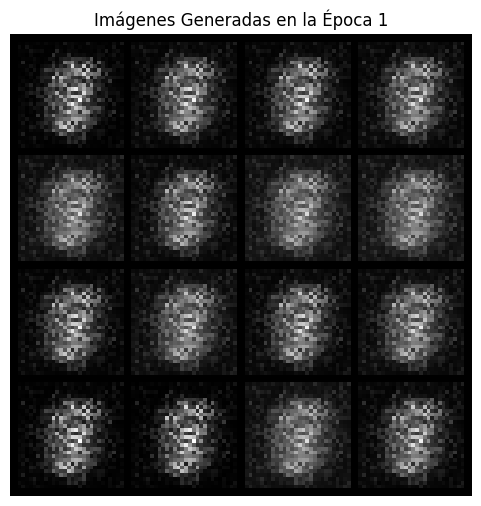

Época [1/50]  D_loss: 0.6071  G_loss: 2.0944


Época 2/50: 100%|██████████| 938/938 [02:00<00:00,  7.79it/s]


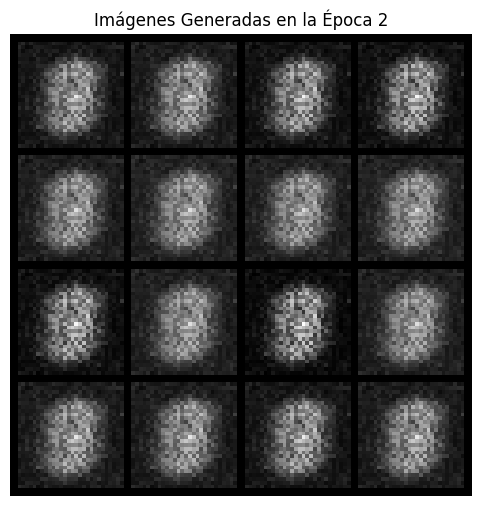

Época [2/50]  D_loss: 0.3801  G_loss: 3.7843


Época 3/50: 100%|██████████| 938/938 [01:55<00:00,  8.14it/s]


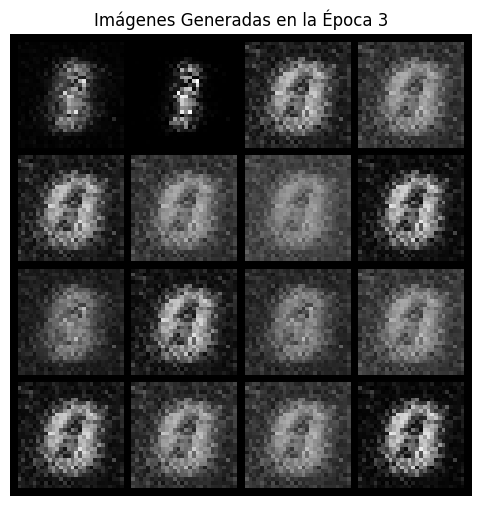

Época [3/50]  D_loss: 0.7323  G_loss: 3.1106


Época 4/50: 100%|██████████| 938/938 [02:03<00:00,  7.61it/s]


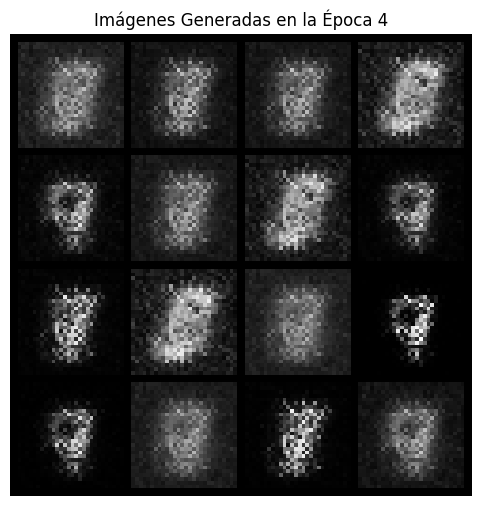

Época [4/50]  D_loss: 0.4849  G_loss: 4.5584


Época 5/50: 100%|██████████| 938/938 [02:00<00:00,  7.76it/s]


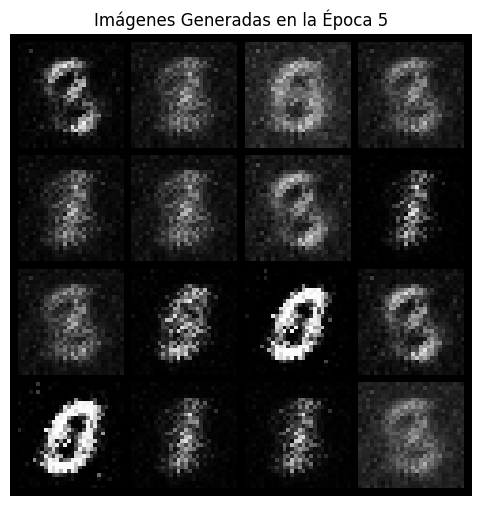

Época [5/50]  D_loss: 0.6237  G_loss: 4.0841


Época 6/50: 100%|██████████| 938/938 [02:00<00:00,  7.77it/s]


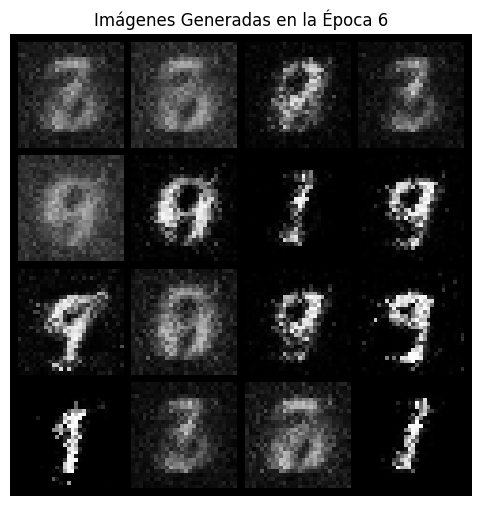

Época [6/50]  D_loss: 0.2307  G_loss: 3.3141


Época 7/50: 100%|██████████| 938/938 [01:59<00:00,  7.85it/s]


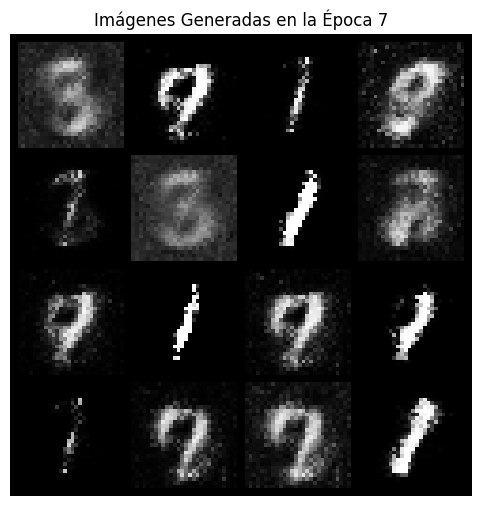

Época [7/50]  D_loss: 0.2244  G_loss: 2.7973


Época 8/50: 100%|██████████| 938/938 [01:59<00:00,  7.87it/s]


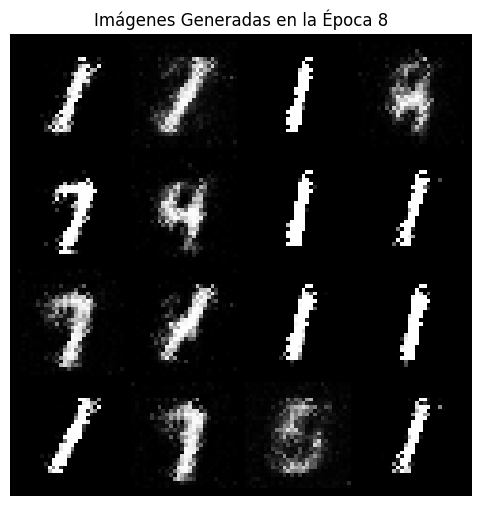

Época [8/50]  D_loss: 0.1826  G_loss: 3.6496


Época 9/50: 100%|██████████| 938/938 [01:59<00:00,  7.85it/s]


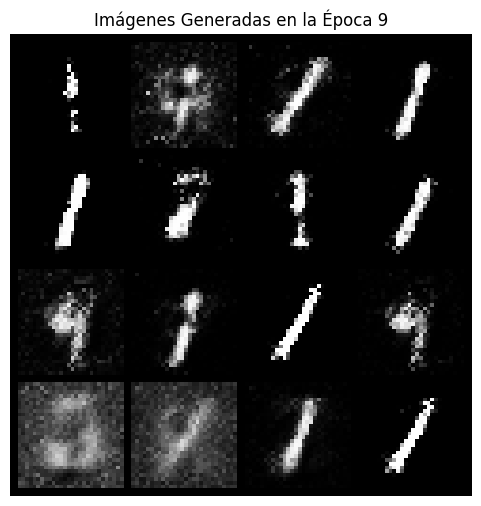

Época [9/50]  D_loss: 0.5678  G_loss: 2.7700


Época 10/50: 100%|██████████| 938/938 [02:04<00:00,  7.56it/s]


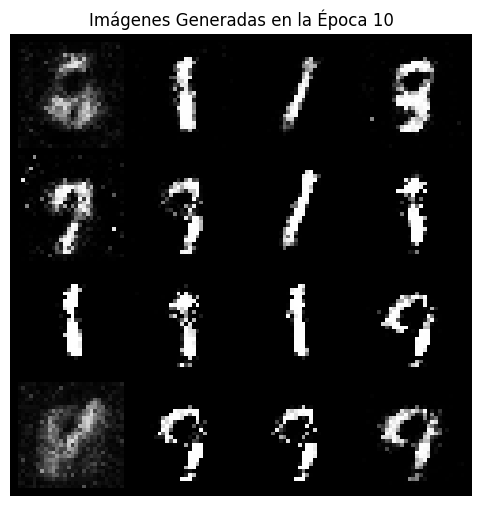

Época [10/50]  D_loss: 0.7436  G_loss: 2.8336


Época 11/50: 100%|██████████| 938/938 [02:01<00:00,  7.72it/s]


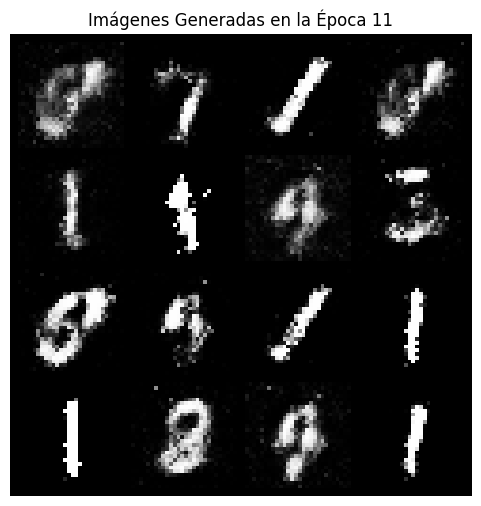

Época [11/50]  D_loss: 0.6478  G_loss: 3.2046


Época 12/50: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s]


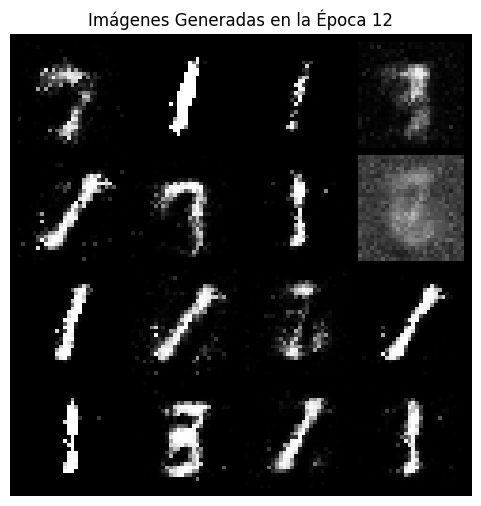

Época [12/50]  D_loss: 1.1326  G_loss: 1.7065


Época 13/50: 100%|██████████| 938/938 [02:03<00:00,  7.56it/s]


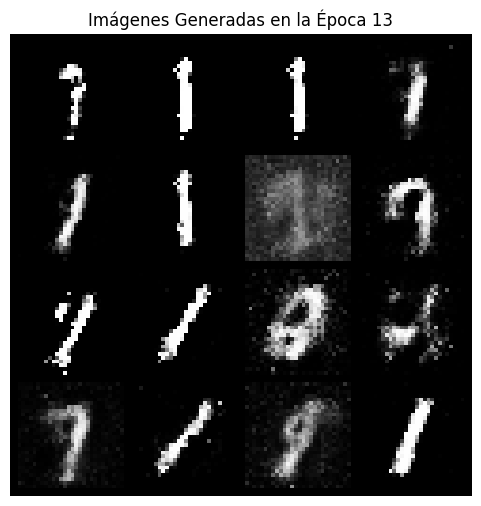

Época [13/50]  D_loss: 0.7231  G_loss: 2.2028


Época 14/50: 100%|██████████| 938/938 [02:03<00:00,  7.58it/s]


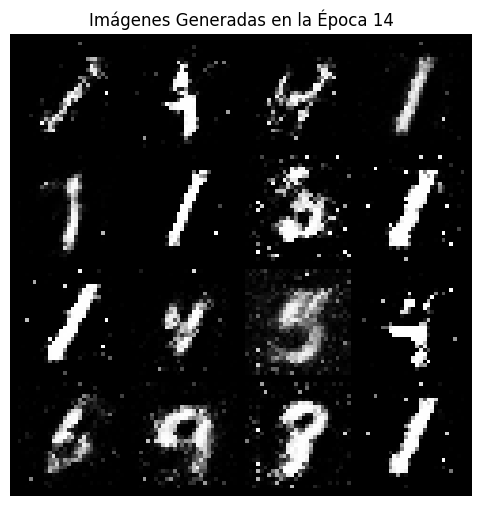

Época [14/50]  D_loss: 0.6848  G_loss: 2.0901


Época 15/50: 100%|██████████| 938/938 [02:04<00:00,  7.52it/s]


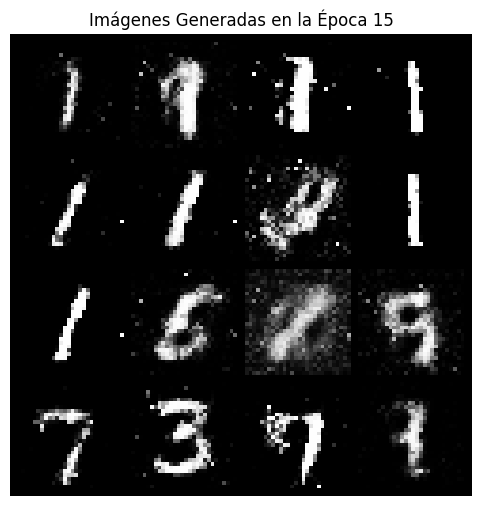

Época [15/50]  D_loss: 1.0678  G_loss: 1.7585


Época 16/50: 100%|██████████| 938/938 [02:07<00:00,  7.35it/s]


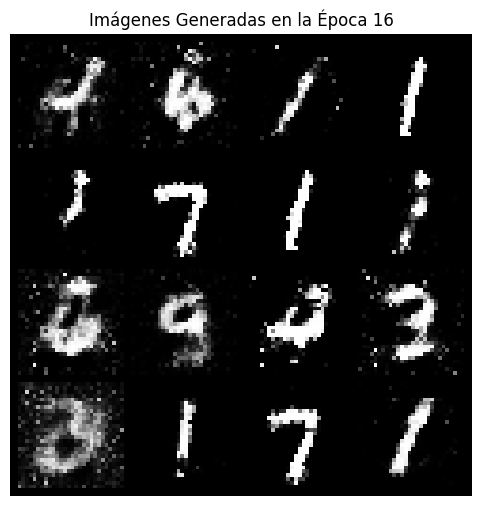

Época [16/50]  D_loss: 0.4807  G_loss: 2.1860


Época 17/50: 100%|██████████| 938/938 [02:06<00:00,  7.41it/s]


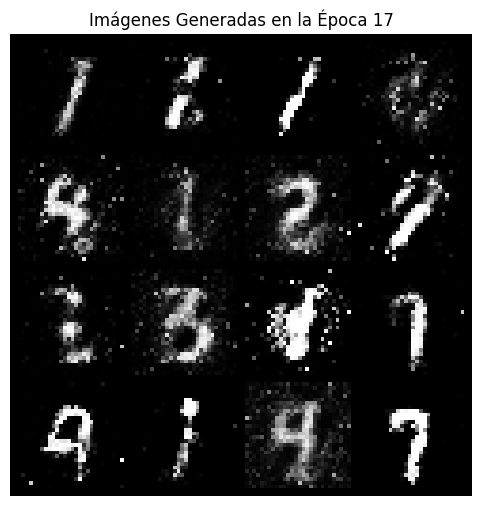

Época [17/50]  D_loss: 0.5727  G_loss: 2.3202


Época 18/50: 100%|██████████| 938/938 [02:06<00:00,  7.44it/s]


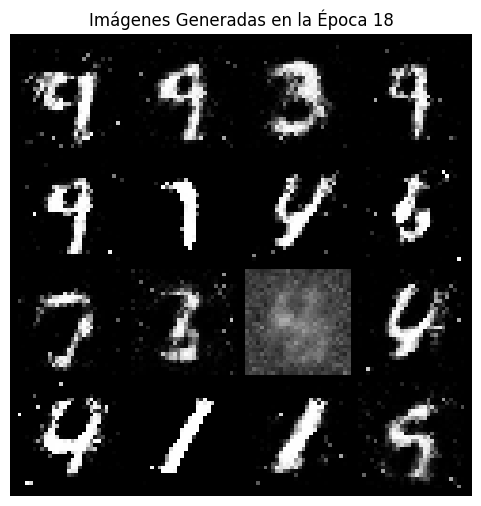

Época [18/50]  D_loss: 0.7423  G_loss: 2.1413


Época 19/50: 100%|██████████| 938/938 [02:04<00:00,  7.50it/s]


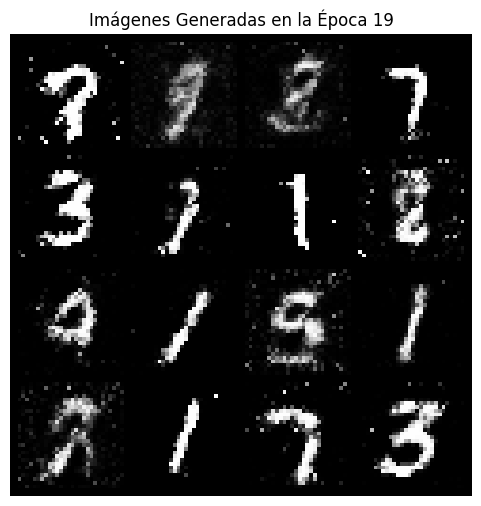

Época [19/50]  D_loss: 0.8488  G_loss: 1.8105


Época 20/50: 100%|██████████| 938/938 [02:06<00:00,  7.41it/s]


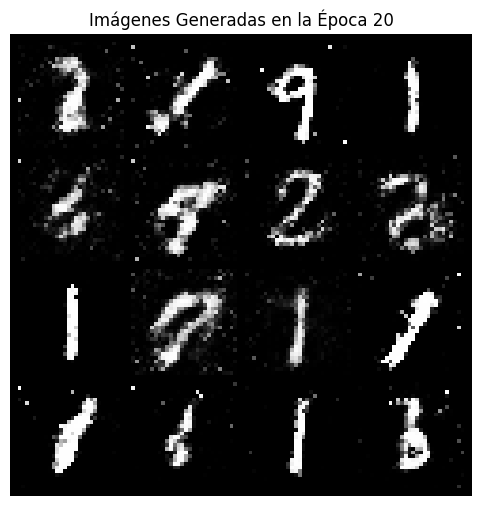

Época [20/50]  D_loss: 0.6012  G_loss: 1.8316


Época 21/50: 100%|██████████| 938/938 [02:05<00:00,  7.47it/s]


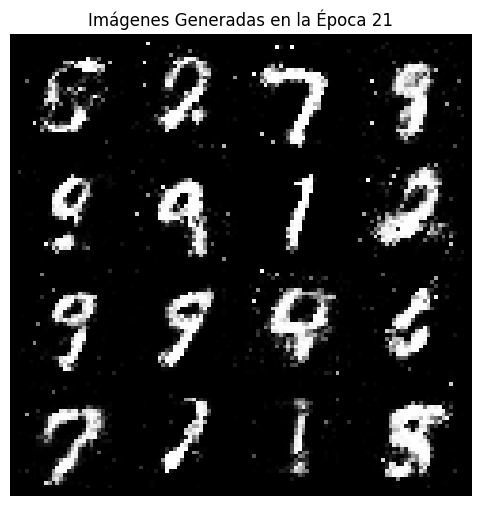

Época [21/50]  D_loss: 0.8934  G_loss: 1.5495


Época 22/50: 100%|██████████| 938/938 [02:07<00:00,  7.34it/s]


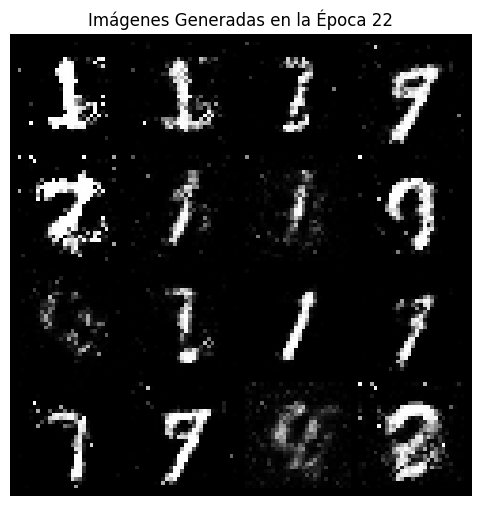

Época [22/50]  D_loss: 0.7482  G_loss: 1.2125


Época 23/50: 100%|██████████| 938/938 [02:06<00:00,  7.42it/s]


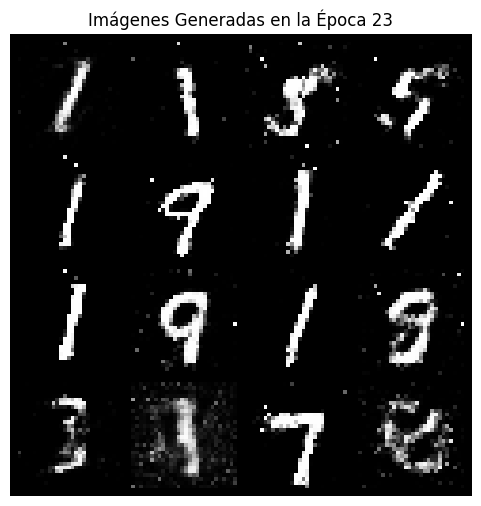

Época [23/50]  D_loss: 1.1039  G_loss: 1.4890


Época 24/50: 100%|██████████| 938/938 [02:07<00:00,  7.37it/s]


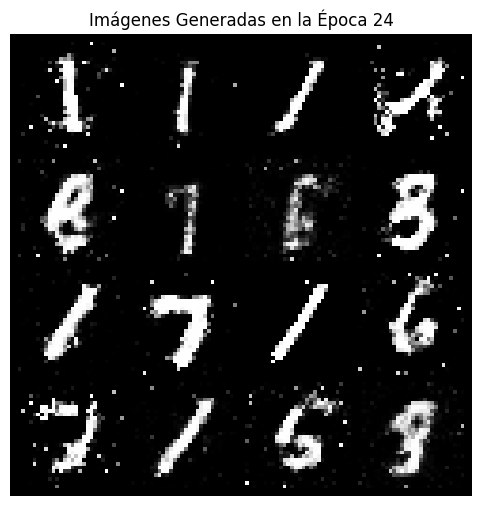

Época [24/50]  D_loss: 0.6665  G_loss: 1.9279


Época 25/50: 100%|██████████| 938/938 [02:05<00:00,  7.45it/s]


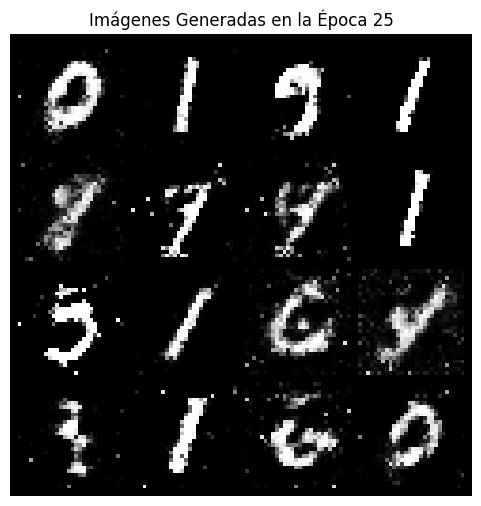

Época [25/50]  D_loss: 0.7247  G_loss: 1.6729


Época 26/50: 100%|██████████| 938/938 [02:07<00:00,  7.37it/s]


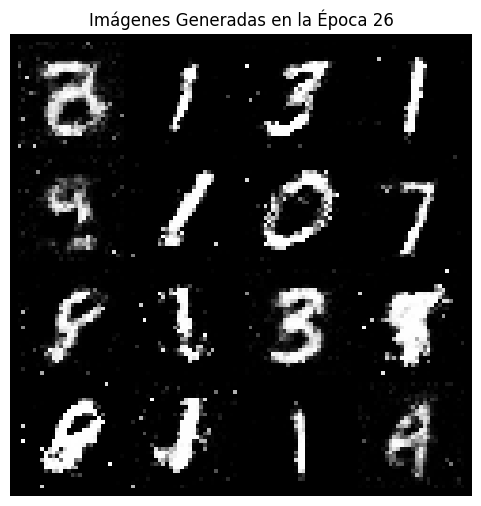

Época [26/50]  D_loss: 0.9594  G_loss: 1.4516


Época 27/50: 100%|██████████| 938/938 [02:09<00:00,  7.24it/s]


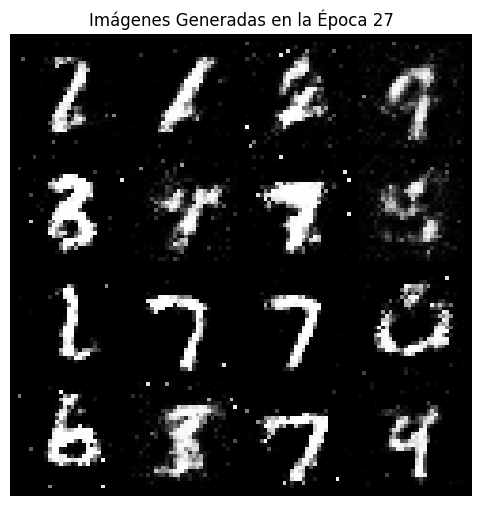

Época [27/50]  D_loss: 1.1536  G_loss: 1.4031


Época 28/50: 100%|██████████| 938/938 [02:08<00:00,  7.28it/s]


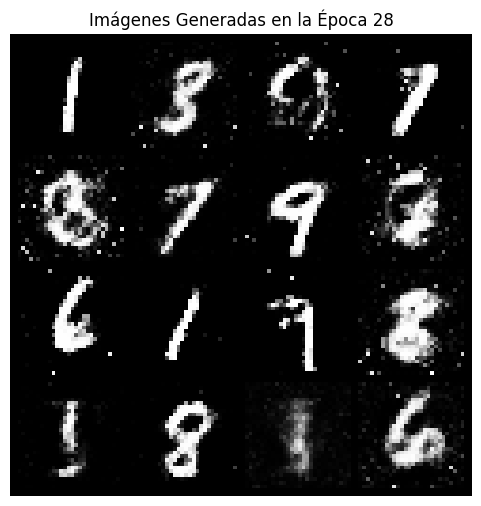

Época [28/50]  D_loss: 0.8976  G_loss: 1.4398


Época 29/50: 100%|██████████| 938/938 [02:06<00:00,  7.42it/s]


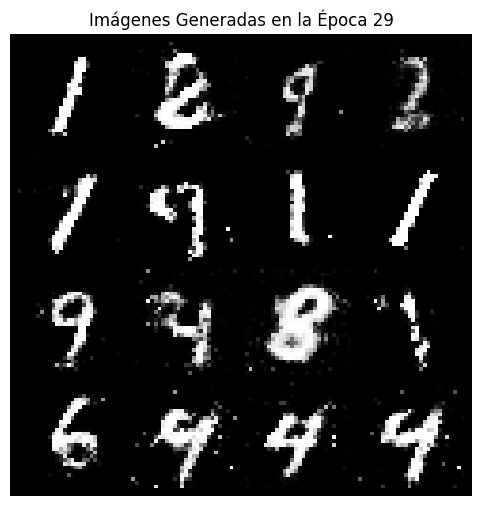

Época [29/50]  D_loss: 0.7820  G_loss: 1.3427


Época 30/50: 100%|██████████| 938/938 [02:08<00:00,  7.30it/s]


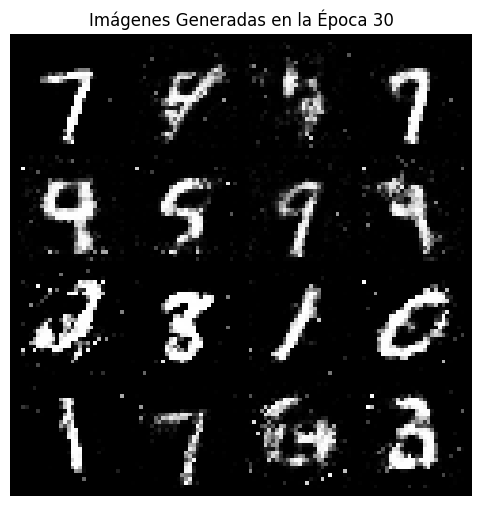

Época [30/50]  D_loss: 0.8154  G_loss: 1.5059


Época 31/50: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s]


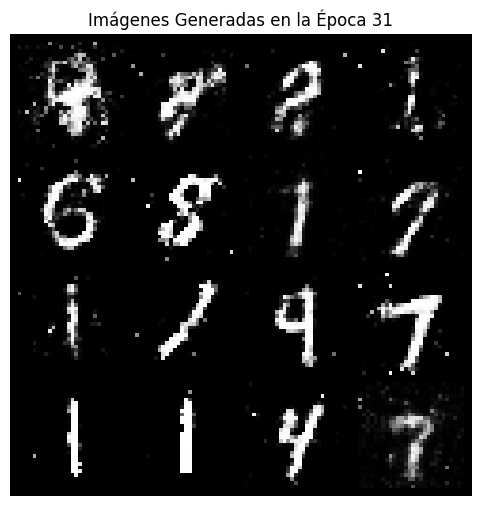

Época [31/50]  D_loss: 0.6336  G_loss: 1.2961


Época 32/50: 100%|██████████| 938/938 [02:09<00:00,  7.23it/s]


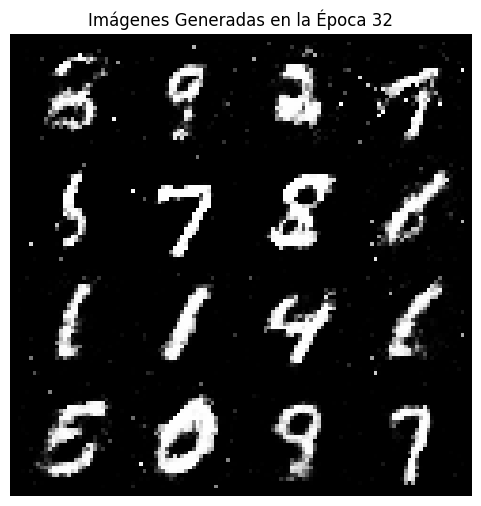

Época [32/50]  D_loss: 1.1977  G_loss: 1.4599


Época 33/50: 100%|██████████| 938/938 [02:10<00:00,  7.21it/s]


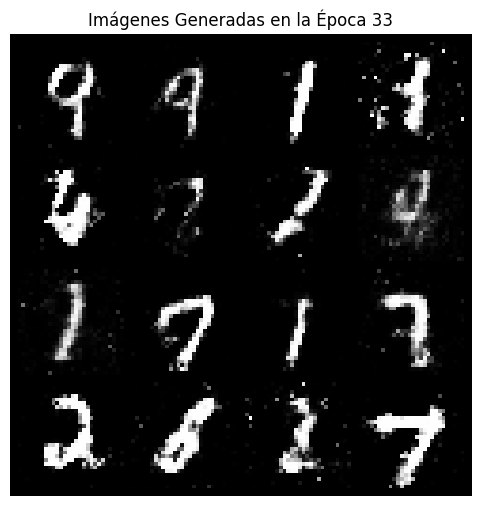

Época [33/50]  D_loss: 0.8281  G_loss: 1.2746


Época 34/50: 100%|██████████| 938/938 [02:09<00:00,  7.22it/s]


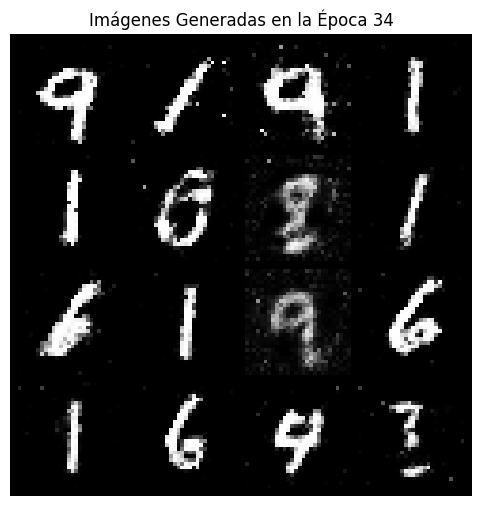

Época [34/50]  D_loss: 0.8338  G_loss: 1.5980


Época 35/50: 100%|██████████| 938/938 [02:11<00:00,  7.13it/s]


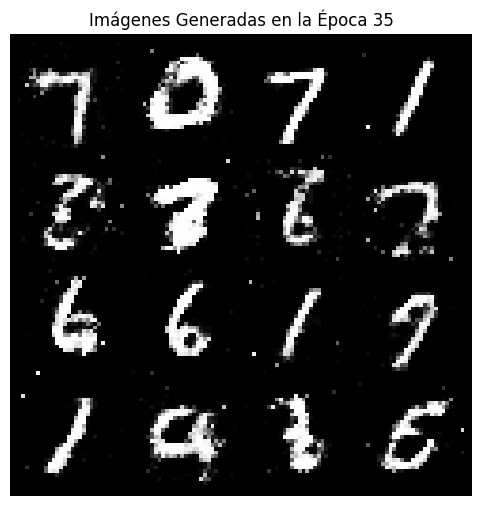

Época [35/50]  D_loss: 1.1773  G_loss: 1.2790


Época 36/50: 100%|██████████| 938/938 [02:10<00:00,  7.17it/s]


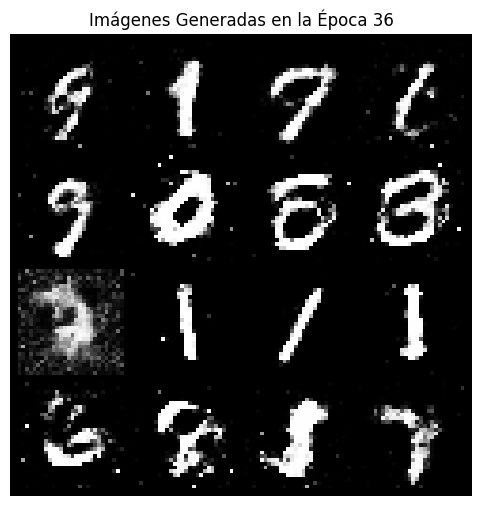

Época [36/50]  D_loss: 0.9673  G_loss: 1.3633


Época 37/50: 100%|██████████| 938/938 [02:11<00:00,  7.13it/s]


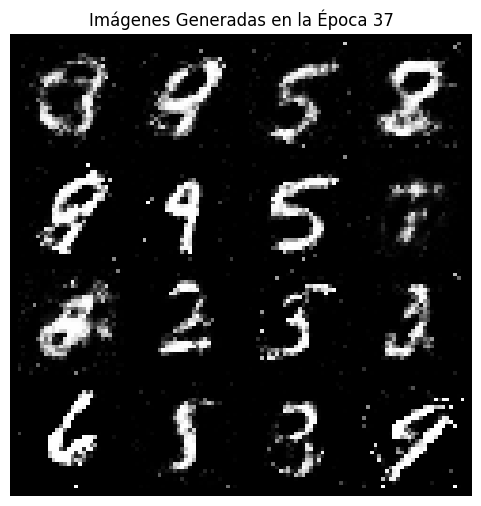

Época [37/50]  D_loss: 1.0315  G_loss: 1.3458


Época 38/50: 100%|██████████| 938/938 [02:14<00:00,  6.99it/s]


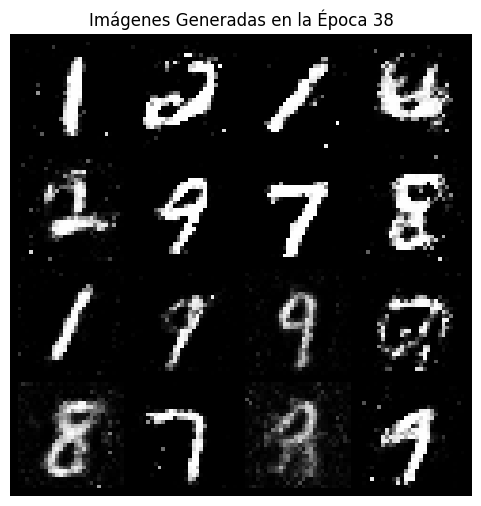

Época [38/50]  D_loss: 0.9991  G_loss: 1.1896


Época 39/50: 100%|██████████| 938/938 [02:14<00:00,  7.00it/s]


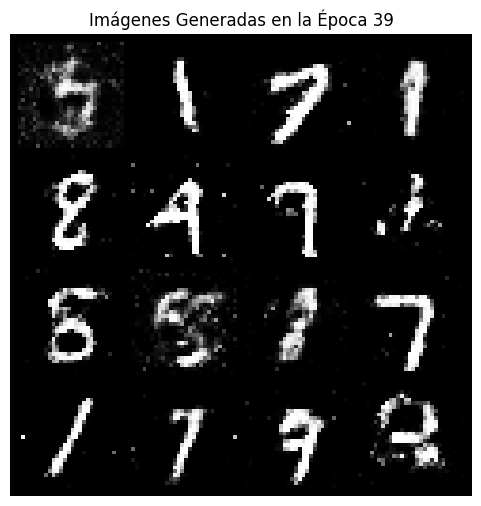

Época [39/50]  D_loss: 0.9745  G_loss: 1.1501


Época 40/50: 100%|██████████| 938/938 [02:13<00:00,  7.02it/s]


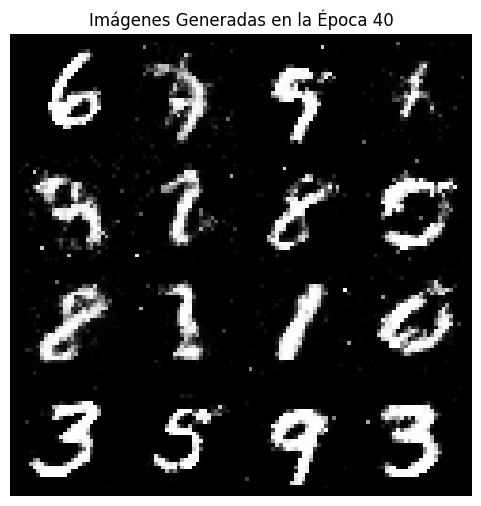

Época [40/50]  D_loss: 0.9194  G_loss: 1.4143


Época 41/50: 100%|██████████| 938/938 [02:12<00:00,  7.05it/s]


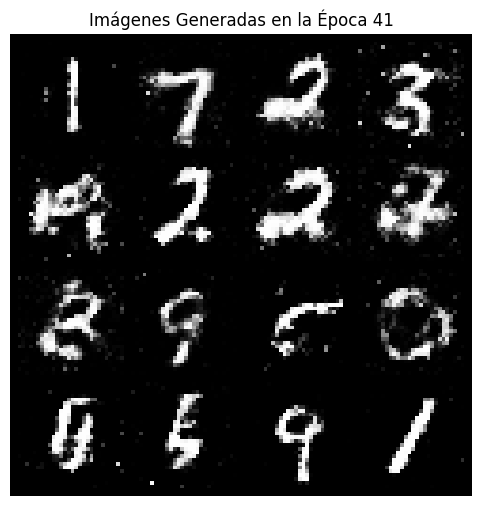

Época [41/50]  D_loss: 1.1282  G_loss: 1.1179


Época 42/50: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


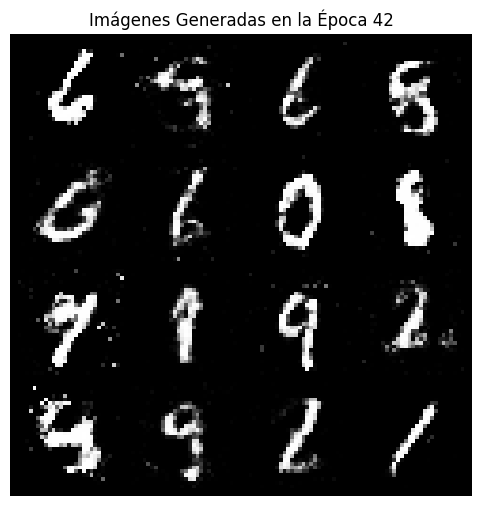

Época [42/50]  D_loss: 1.3342  G_loss: 0.9121


Época 43/50: 100%|██████████| 938/938 [02:17<00:00,  6.82it/s]


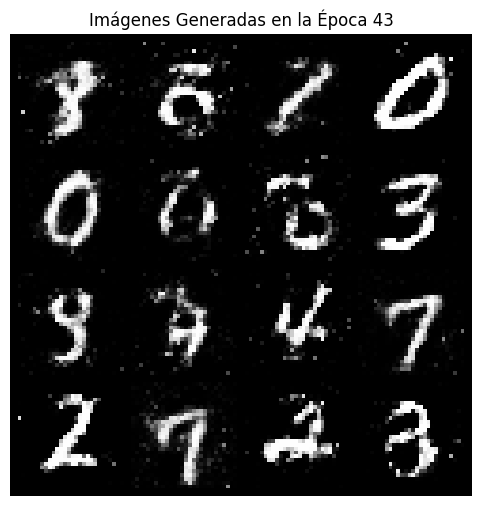

Época [43/50]  D_loss: 1.0116  G_loss: 1.3680


Época 44/50: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


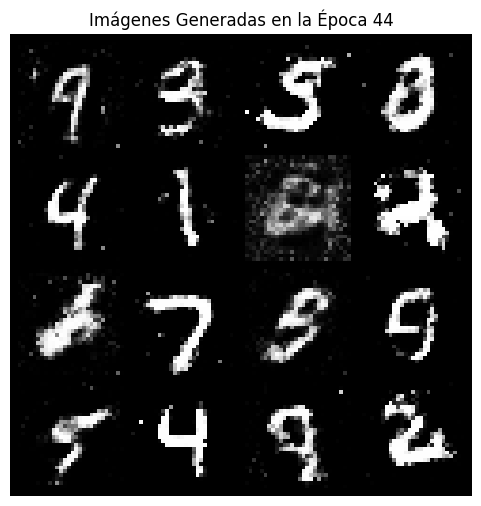

Época [44/50]  D_loss: 1.1458  G_loss: 1.1491


Época 45/50: 100%|██████████| 938/938 [02:13<00:00,  7.04it/s]


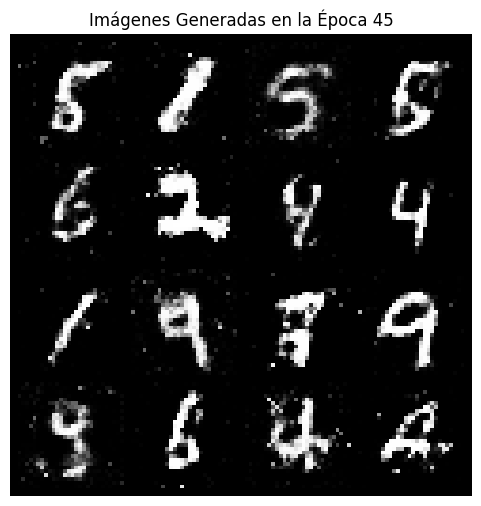

Época [45/50]  D_loss: 1.0266  G_loss: 1.3779


Época 46/50: 100%|██████████| 938/938 [02:12<00:00,  7.09it/s]


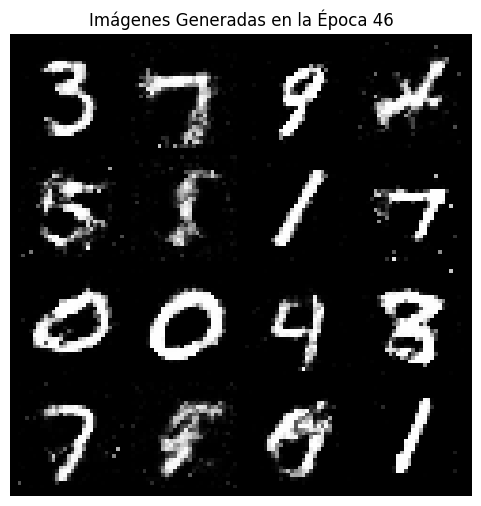

Época [46/50]  D_loss: 1.0221  G_loss: 1.2554


Época 47/50: 100%|██████████| 938/938 [02:12<00:00,  7.07it/s]


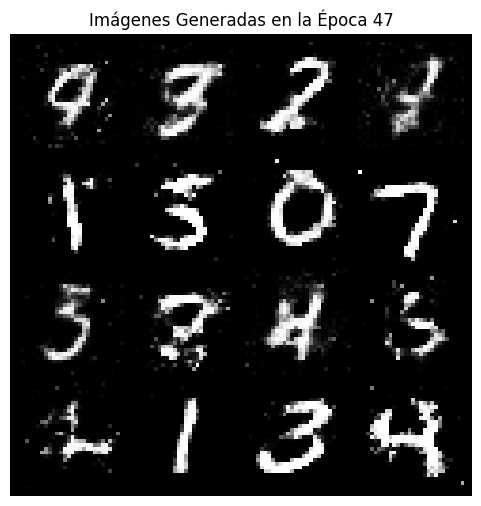

Época [47/50]  D_loss: 1.1652  G_loss: 1.2088


Época 48/50: 100%|██████████| 938/938 [02:15<00:00,  6.90it/s]


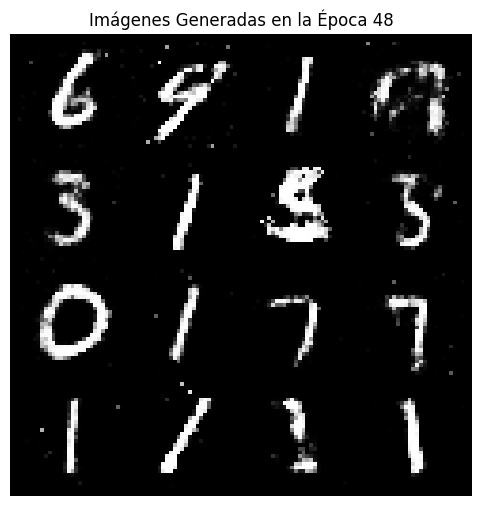

Época [48/50]  D_loss: 1.1078  G_loss: 1.0854


Época 49/50: 100%|██████████| 938/938 [02:18<00:00,  6.77it/s]


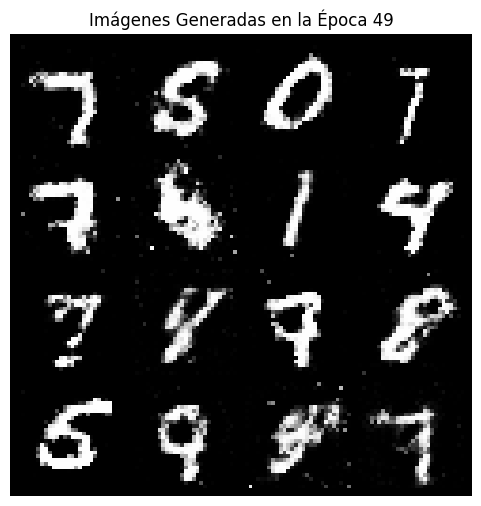

Época [49/50]  D_loss: 0.9815  G_loss: 1.1880


Época 50/50: 100%|██████████| 938/938 [02:15<00:00,  6.94it/s]


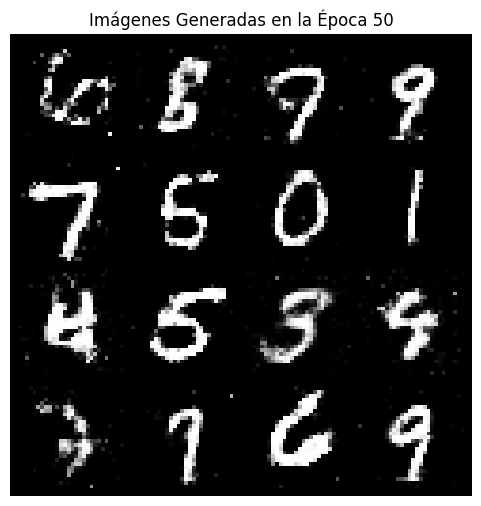

Época [50/50]  D_loss: 1.1046  G_loss: 1.0553


In [8]:
# Carpeta para guardar imágenes generadas
os.makedirs('generated_images', exist_ok=True)

# Bucle de entrenamiento
for epoch in range(1, num_epochs+1):
    for batch_idx, (real_images, _) in enumerate(tqdm(train_loader, desc=f'Época {epoch}/{num_epochs}')):
        batch_size_curr = real_images.size(0)

        # Ajustar etiquetas reales y falsas según el tamaño actual del batch
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # ====================
        # Entrenamiento del Discriminador
        # ====================
        D.zero_grad()

        # Imágenes reales
        real_images = real_images.view(batch_size_curr, -1).to(device)
        outputs = D(real_images)
        D_loss_real = criterion(outputs, real_labels)
        D_loss_real.backward()

        # Imágenes generadas
        z = torch.randn(batch_size_curr, Z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        D_loss_fake.backward()

        # Pérdida total del Discriminador
        D_loss = D_loss_real + D_loss_fake
        D_optimizer.step()

        # ====================
        # Entrenamiento del Generador
        # ====================
        G.zero_grad()

        # Generar nuevas imágenes
        z = torch.randn(batch_size_curr, Z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)  # Queremos que D piense que son reales
        G_loss.backward()
        G_optimizer.step()

    # Mostrar y guardar imágenes generadas al final de cada época
    show_generated_images(epoch, G, device, Z_dim)
    torchvision.utils.save_image(fake_images.view(-1, 1, 28, 28), f'generated_images/epoch_{epoch}.png', normalize=True)

    print(f'Época [{epoch}/{num_epochs}]  D_loss: {D_loss.item():.4f}  G_loss: {G_loss.item():.4f}')


Explicación: Este es el bucle principal de entrenamiento donde:

Entrenamiento del Discriminador:

* Se actualiza para distinguir entre imágenes reales y generadas.
* Calcula la pérdida en imágenes reales (D_loss_real) y generadas (D_loss_fake).
* Retropropaga y actualiza los pesos del discriminador.

Entrenamiento del Generador:

* Se actualiza para engañar al discriminador.
* Genera nuevas imágenes y calcula la pérdida basada en cómo el discriminador las clasifica.
* Retropropaga y actualiza los pesos del generador.

Visualización y Guardado:

* Al final de cada época, se generan y muestran imágenes nuevas.
* Se guardan las imágenes generadas en la carpeta generated_images para su posterior revisión.

Monitoreo de Pérdidas:

* Imprime las pérdidas del discriminador y generador al final de cada época para evaluar el progreso del entrenamiento.

**Celda 7: Visualización de Imágenes Generadas Después del Entrenamiento**

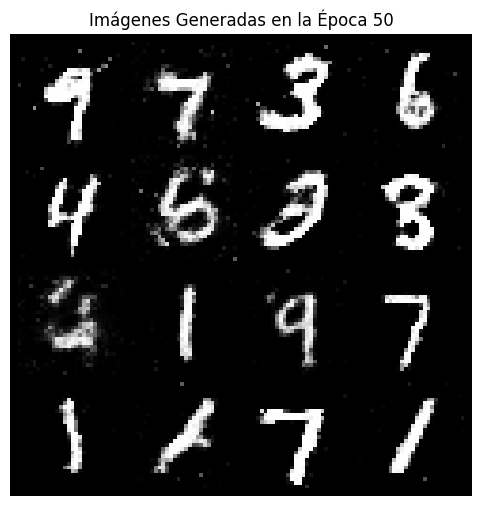

In [9]:
# Mostrar algunas imágenes generadas después del entrenamiento
show_generated_images(num_epochs, G, device, Z_dim)


Explicación: Después de completar el entrenamiento, esta celda genera y muestra un conjunto final de imágenes utilizando el generador entrenado.

## **Conclusión**

En este ejercicio, hemos implementado una **GAN Vanilla** utilizando **PyTorch** para generar imágenes similares a los dígitos escritos a mano del conjunto de datos **MNIST**. A lo largo del ejercicio, hemos aprendido:

1. **Estructura de una GAN:**
   - **Generador (Generator):** Red neuronal que genera imágenes a partir de vectores de ruido.
   - **Discriminador (Discriminator):** Red neuronal que clasifica imágenes como reales o generadas.

2. **Entrenamiento de la GAN:**
   - Alternar entre el entrenamiento del discriminador y el generador.
   - Utilizar la función de pérdida de entropía cruzada binaria (`BCELoss`) para ambas redes.

3. **Visualización de Resultados:**
   - Generar y visualizar imágenes a lo largo del entrenamiento para observar cómo mejora la calidad de las imágenes generadas.

### **Observaciones:**

- **Estabilidad del Entrenamiento:**
  - Las GANs pueden ser sensibles a la configuración de hiperparámetros y la arquitectura de las redes. Asegúrate de ajustar la tasa de aprendizaje y las dimensiones de las capas si las imágenes generadas no mejoran con el tiempo.

- **Mejora de Resultados:**
  - Experimenta con arquitecturas más profundas o diferentes funciones de activación.
  - Implementa técnicas como **Batch Normalization** en el generador y discriminador para mejorar la estabilidad del entrenamiento.

- **Interpretación de las Pérdidas:**
  - Un equilibrio entre las pérdidas del generador y el discriminador indica un buen entrenamiento. Si una red domina sobre la otra, puede llevar a resultados subóptimos.

### **Próximos Pasos:**

Para profundizar en el tema de las GANs, considera explorar variantes más avanzadas como:
- **Deep Convolutional GANs (DCGANs):** Utilizan capas convolucionales para generar imágenes de mayor calidad.
- **Conditional GANs:** Permiten generar imágenes condicionadas a ciertas etiquetas o características.
- **Wasserstein GANs (WGANs):** Mejoran la estabilidad del entrenamiento y la calidad de las imágenes generadas.

Si deseas obtener más información y mejorar tus GANs, te recomiendo ver el siguiente video de **Soumith Chintala**, uno de los creadores de PyTorch, que describe cómo entrenar y mejorar las GANs:

[**Video de Soumith Chintala sobre GANs**](https://www.youtube.com/watch?v=myGAju4L7O8)

¡Felicidades por completar el ejercicio!
